In [123]:
import os, time, h5py, platform, json, sys
if platform.system() == 'Linux':
    import matplotlib
    matplotlib.use('Agg')
sys.path.append("/Users/gkoolstra/Documents/Code")
from matplotlib import pyplot as plt
from shutil import copyfile
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from termcolor import cprint
from Common import common, kfit
from TrapAnalysis import trap_analysis, artificial_anneal as anneal
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [124]:
from numpy import *
from scipy import *
from qutip import *

def S21(wc, wa, wd, g, kappa, gamma, drive_strength=0.01):
    hilbert_size = 10  # number of cavity fock states
    
    # operators
    a  = tensor(destroy(hilbert_size), qeye(2))
    sm = tensor(qeye(hilbert_size), destroy(2))
    sz = tensor(qeye(hilbert_size), sigmaz())

    # collapse operators
    c_op_list = []
    if gamma > 0.0:
        c_op_list.append(sqrt(gamma) * sm)  # atom decay operator
    if kappa > 0.0:
        c_op_list.append(sqrt(kappa) * a)  # cavity decay operator

    na = sm.dag() * sm  # atom
    nc = a.dag() * a    # cavity

    final_states = list()

    for i, wdrive in enumerate(wd):
        # decoupled Hamiltonian
        H0 = (wc-wdrive) * a.dag() * a + (wa-wdrive)/2. * sz + drive_strength*(a + a.dag())
        H1 = (a.dag() * sm + a * sm.dag())    
        H = H0 + g * H1
        final_state = steadystate(H, c_op_list)
        final_states.append(expect([-1j*(a-a.dag()), a+a.dag()], final_state)) #[mag, phase]
        
    return np.array(final_states)

In [ ]:
H

In [102]:
wc = 2 * pi * 6.40E9  # cavity frequency
kappa = wc/1E4
was = linspace(wc-200*kappa, wc+200*kappa, 51)  # atom frequency
wds = linspace(wc-8*kappa, wc+8*kappa, 81)
g = 2 * pi * 3E6
gamma = 40.0*g #0.10*kappa #0.99 * g

magnitudes = list()
phases = list()
for wa in tqdm(was):
    transmission = S21(wc, wa, wds, g, kappa, gamma)
    magnitudes.append(np.abs(transmission[:, 0]))
    phases.append(transmission[:, 1])
magnitudes = np.array(magnitudes)
phases = np.array(phases)

100%|██████████| 51/51 [00:37<00:00,  1.38it/s]


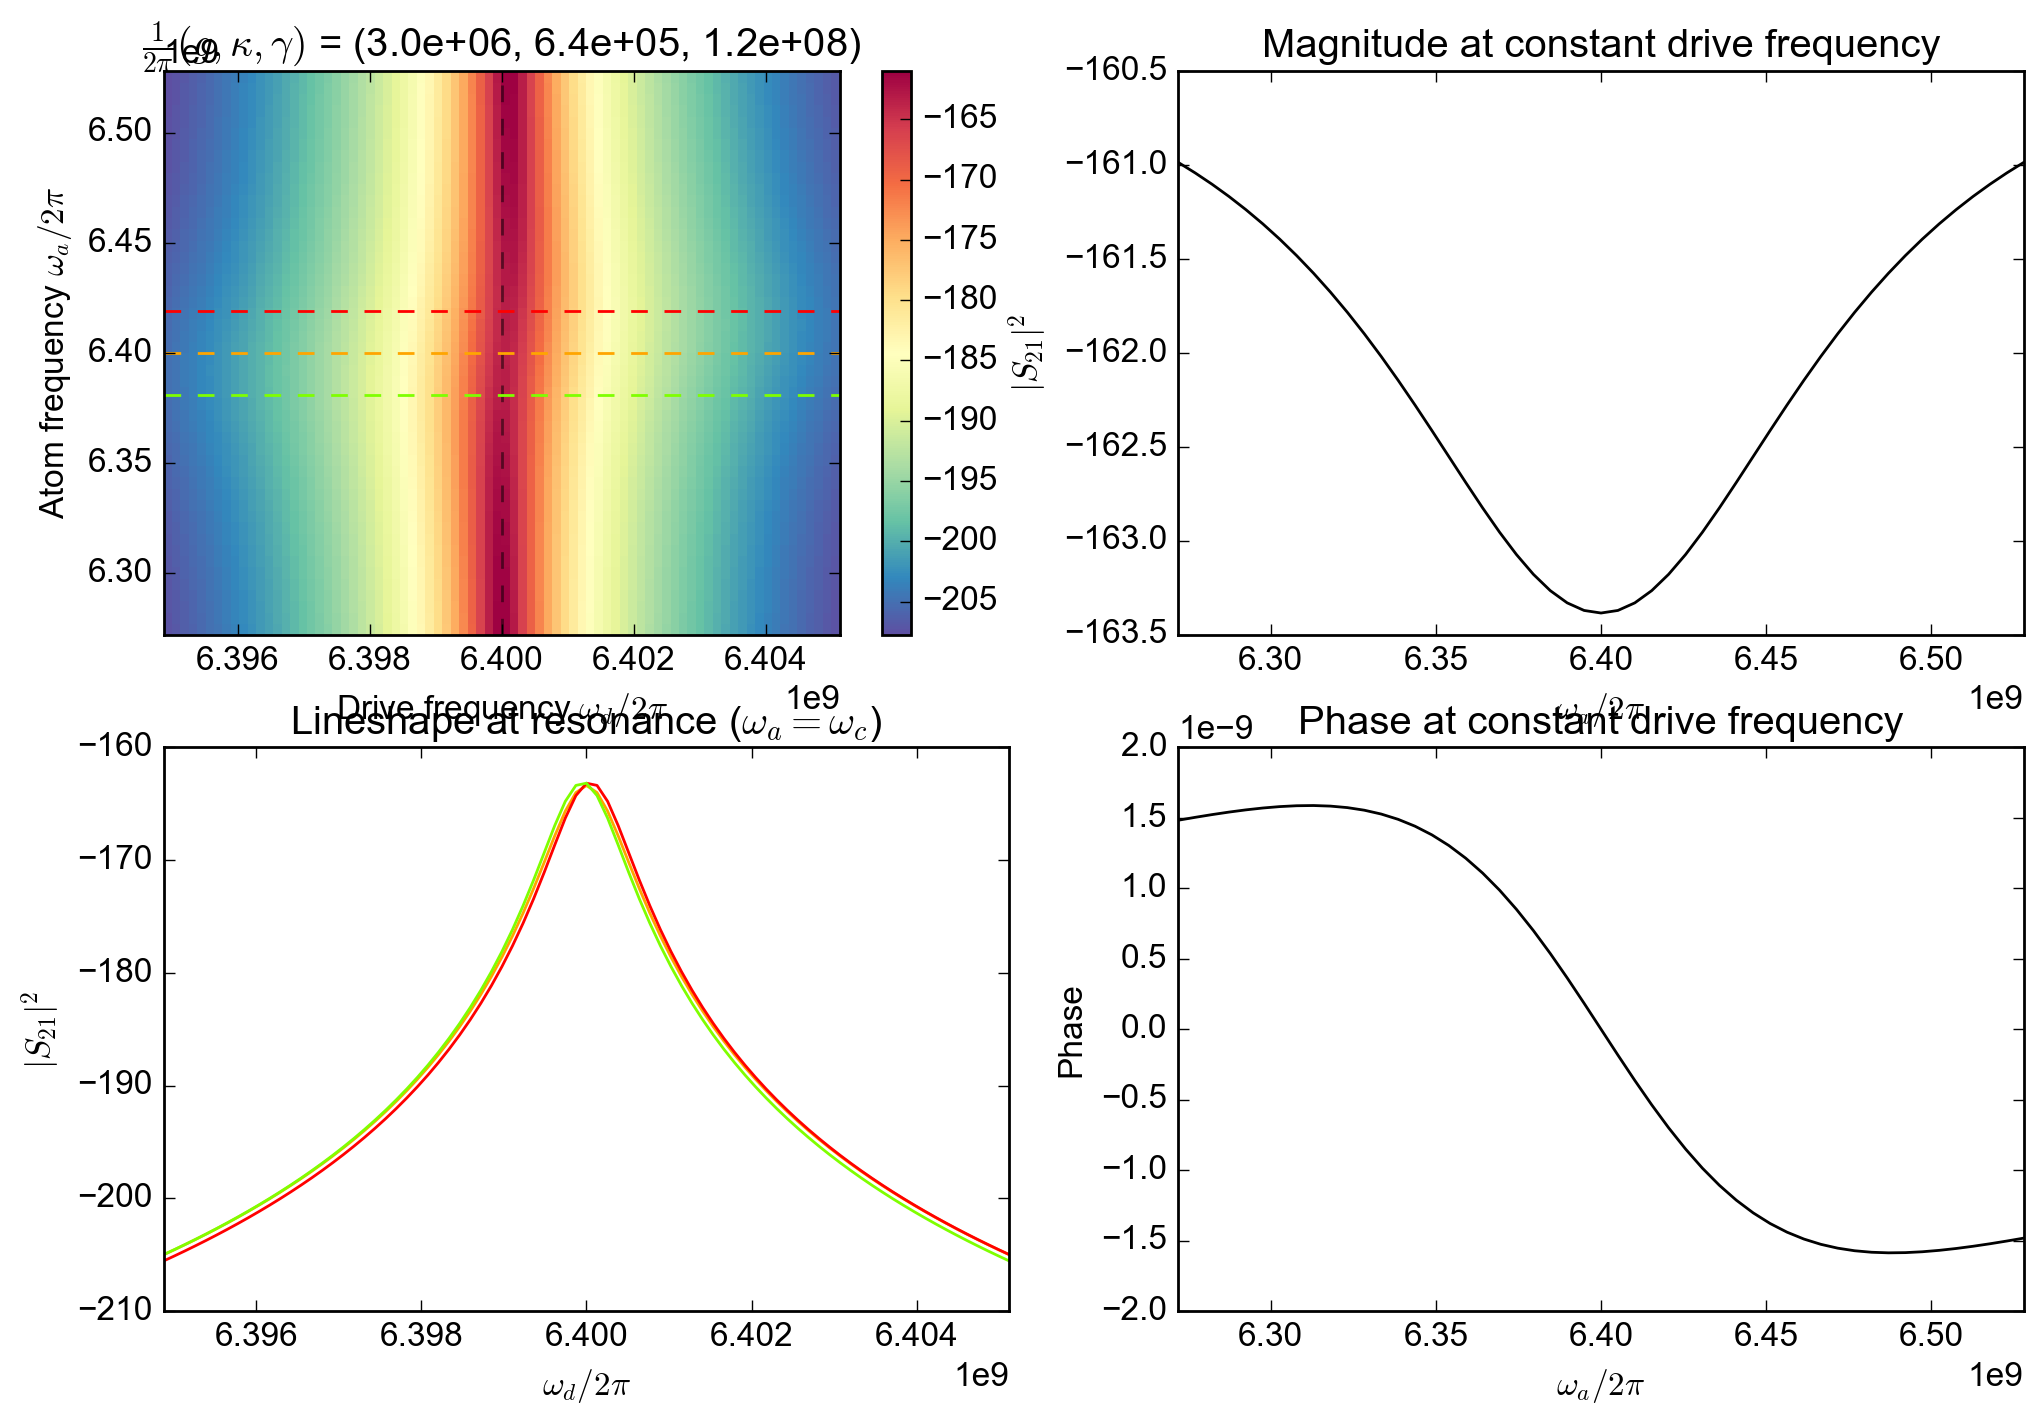

In [104]:
color1 = 'k'
color2 = 'orange'
color3 = 'red'
color4 = 'chartreuse'

point3 = (wc+30*kappa)/(2*pi)
point4 = (wc-30*kappa)/(2*pi)

plt.figure(figsize=(12.,8.))
common.configure_axes(12)
plt.subplot(221)
plt.pcolormesh(wds/(2*pi), was/(2*pi), 20*np.log10(magnitudes), 
               cmap=plt.cm.Spectral_r)#, vmin=-100, vmax=-40)
plt.title(r"$\frac{1}{2\pi} (g, \kappa, \gamma)$ = (%.1e, %.1e, %.1e)"%(g/(2*pi), kappa/(2*pi), gamma/(2*pi)))
plt.xlabel("Drive frequency $\omega_d / 2\pi$")
plt.ylabel("Atom frequency $\omega_a / 2\pi$")
plt.colorbar()
plt.xlim(min(wds)/(2*pi), max(wds)/(2*pi))
plt.ylim(min(was)/(2*pi), max(was)/(2*pi))
plt.axvline(wc/(2*pi), linestyle='--', color=color1, alpha=0.5)
plt.axhline(wc/(2*pi), linestyle='--', color=color2, alpha=1.0)
plt.axhline(point3, linestyle='--', color=color3, alpha=1.0)
plt.axhline(point4, linestyle='--', color=color4, alpha=1.0)


resonance_idx = common.find_nearest(wds, wc)
plt.subplot(222)
plt.plot(was/(2*pi), 20*np.log10(magnitudes[:, resonance_idx]), color=color1)
plt.xlabel("$\omega_a/2\pi$")
plt.ylabel("$|S_{21}|^2$")
plt.xlim(min(was/(2*pi)), max(was)/(2*pi))
plt.title("Magnitude at constant drive frequency")

plt.subplot(224)
plt.plot(was/(2*pi), phases[:, resonance_idx], color=color1)
plt.xlabel("$\omega_a/2\pi$")
plt.ylabel("Phase")
plt.xlim(min(was/(2*pi)), max(was)/(2*pi))
plt.title("Phase at constant drive frequency")


resonance_idx = common.find_nearest(was, wc)
point3_idx = common.find_nearest(was/(2*pi), point3)
point4_idx = common.find_nearest(was/(2*pi), point4)

plt.subplot(223)
plt.plot(wds/(2*pi), 20*np.log10(magnitudes[resonance_idx, :]), color=color2)
plt.plot(wds/(2*pi), 20*np.log10(magnitudes[point3_idx, :]), color=color3)
plt.plot(wds/(2*pi), 20*np.log10(magnitudes[point4_idx, :]), color=color4)
plt.xlabel("$\omega_d/2\pi$")
plt.ylabel("$|S_{21}|^2$")
plt.xlim(min(wds/(2*pi)), max(wds)/(2*pi))
plt.title("Lineshape at resonance ($\omega_a = \omega_c$)")

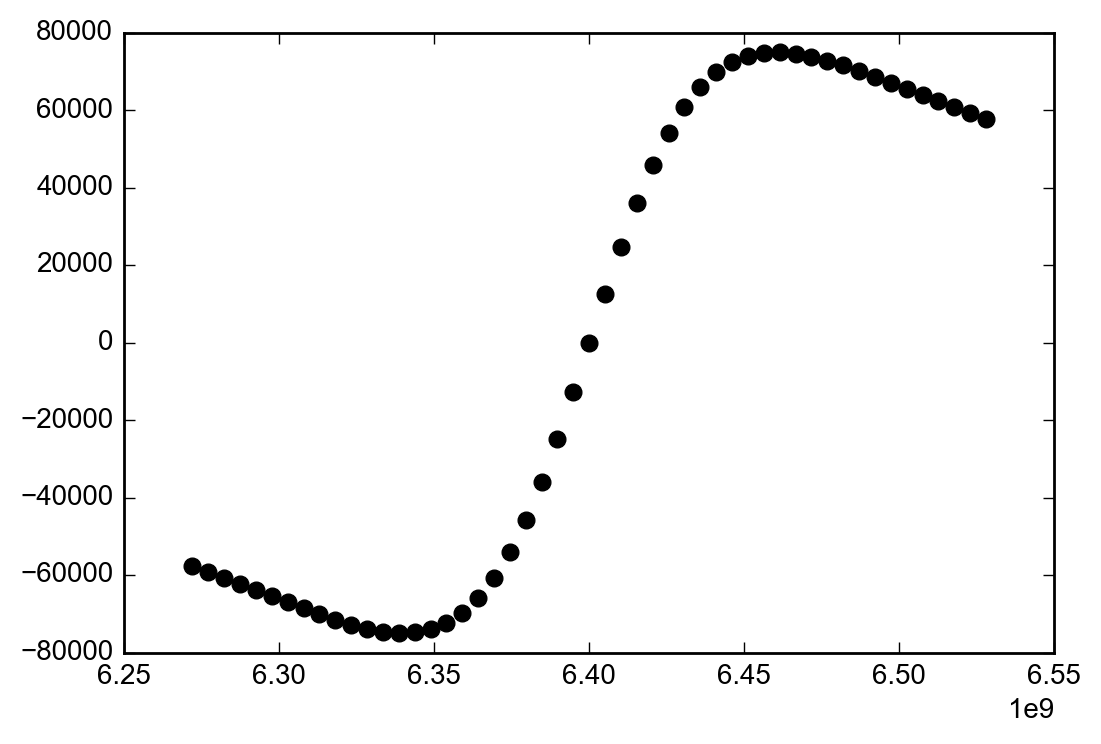

In [122]:
for p in range(np.shape(magnitudes)[0]):
    center = 1/(2*pi) * wds[np.argmax(magnitudes[p, :])]
    fr, ferr = kfit.fit_lor(wds/(2*pi), magnitudes[p, :], verbose=False, no_offset=True, 
                            domain=(center-1E6, center+1E6))
#     if p == 0:
#         plt.plot(wds/(2*pi), magnitudes[p, :], 'ok')
#         plt.plot(wds/(2*pi), kfit.lorfunc(wds/(2*pi), *fr))
        
    plt.plot(was[p]/(2*pi), fr[1]-wc/(2*pi), 'ok')

In [43]:
def X2(wc, wa, wd, g, kappa, gamma):
    return np.abs((-wd**2 + wa**2 + 1j*wd*gamma)/((-wd**2+wa**2+1j*wd*gamma)*(-wd**2+wc**2+1j*wd*kappa) - g**2))

In [63]:
wds = linspace(min(wds), max(wds), 501)
magnitudes = list()
for wa in tqdm(was):
    magnitudes.append(X2(wc, wa, wds, g, kappa, gamma))
magnitudes = np.array(magnitudes)

100%|██████████| 51/51 [00:00<00:00, 12695.68it/s]


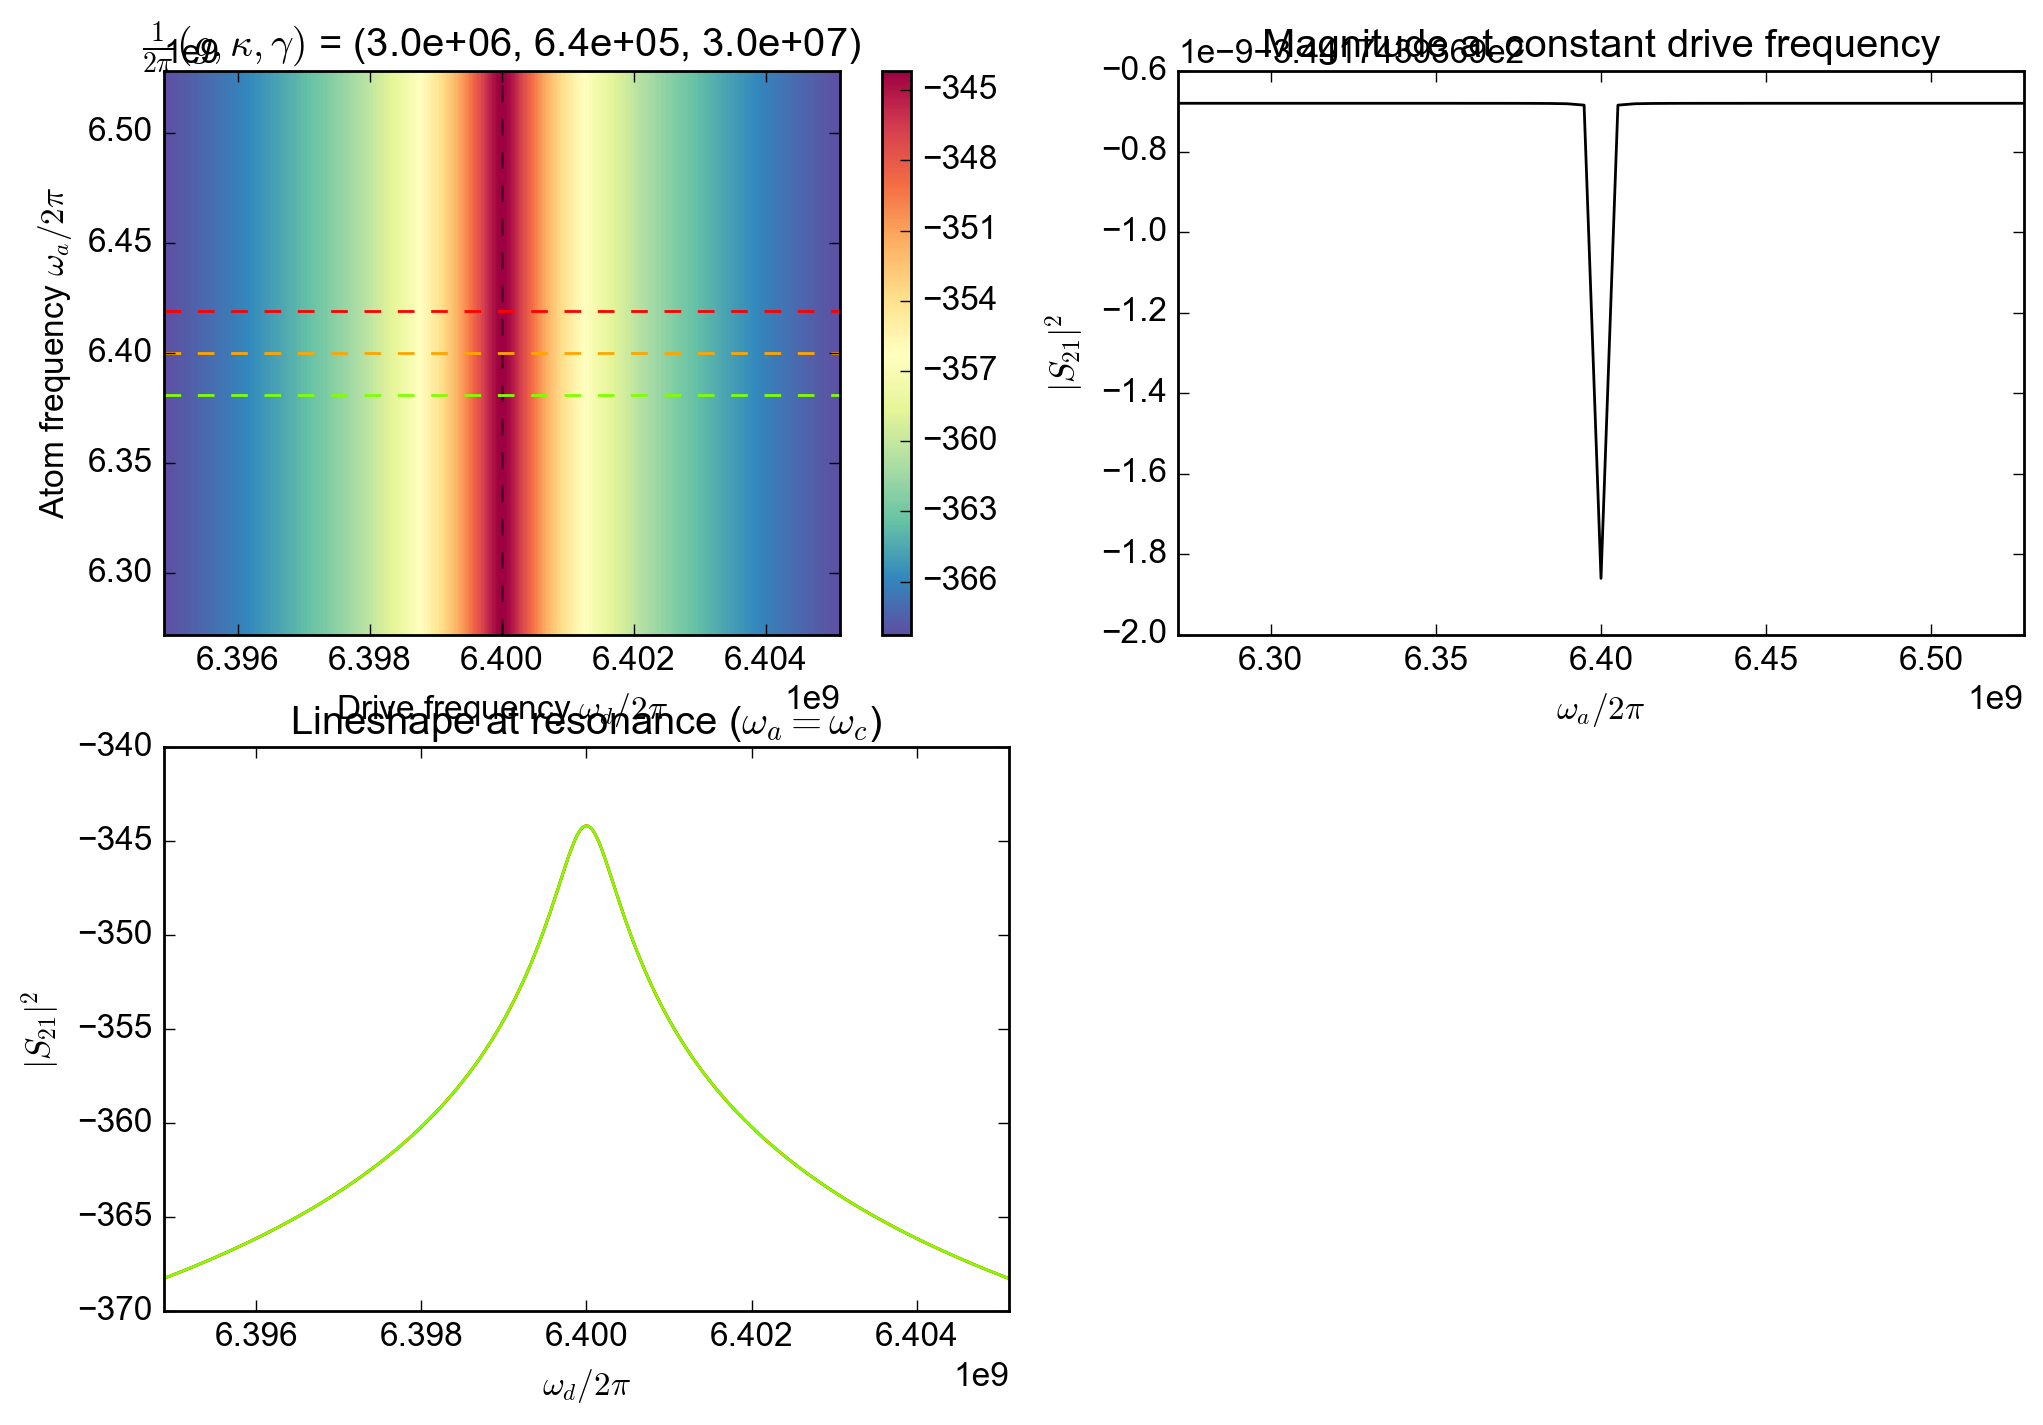

In [64]:
color1 = 'k'
color2 = 'orange'
color3 = 'red'
color4 = 'chartreuse'

point3 = (wc+30*kappa)/(2*pi)
point4 = (wc-30*kappa)/(2*pi)

plt.figure(figsize=(12.,8.))
common.configure_axes(12)
plt.subplot(221)
plt.pcolormesh(wds/(2*pi), was/(2*pi), 20*np.log10(magnitudes), 
               cmap=plt.cm.Spectral_r)#, vmin=-100, vmax=-40)
plt.title(r"$\frac{1}{2\pi} (g, \kappa, \gamma)$ = (%.1e, %.1e, %.1e)"%(g/(2*pi), kappa/(2*pi), gamma/(2*pi)))
plt.xlabel("Drive frequency $\omega_d / 2\pi$")
plt.ylabel("Atom frequency $\omega_a / 2\pi$")
plt.colorbar()
plt.xlim(min(wds)/(2*pi), max(wds)/(2*pi))
plt.ylim(min(was)/(2*pi), max(was)/(2*pi))
plt.axvline(wc/(2*pi), linestyle='--', color=color1, alpha=0.5)
plt.axhline(wc/(2*pi), linestyle='--', color=color2, alpha=1.0)
plt.axhline(point3, linestyle='--', color=color3, alpha=1.0)
plt.axhline(point4, linestyle='--', color=color4, alpha=1.0)


resonance_idx = common.find_nearest(wds, wc)
plt.subplot(222)
plt.plot(was/(2*pi), 20*np.log10(magnitudes[:, resonance_idx]), color=color1)
plt.xlabel("$\omega_a/2\pi$")
plt.ylabel("$|S_{21}|^2$")
plt.xlim(min(was/(2*pi)), max(was)/(2*pi))
plt.title("Magnitude at constant drive frequency")

resonance_idx = common.find_nearest(was, wc)
point3_idx = common.find_nearest(was/(2*pi), point3)
point4_idx = common.find_nearest(was/(2*pi), point4)

plt.subplot(223)
plt.plot(wds/(2*pi), 20*np.log10(magnitudes[resonance_idx, :]), color=color2)
plt.plot(wds/(2*pi), 20*np.log10(magnitudes[point3_idx, :]), color=color3)
plt.plot(wds/(2*pi), 20*np.log10(magnitudes[point4_idx, :]), color=color4)
plt.xlabel("$\omega_d/2\pi$")
plt.ylabel("$|S_{21}|^2$")
plt.xlim(min(wds/(2*pi)), max(wds)/(2*pi))
plt.title("Lineshape at resonance ($\omega_a = \omega_c$)")
